In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from datetime import datetime, timedelta
import math
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import warnings
warnings.filterwarnings('ignore')
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Step 1: Data preparation and scaling

#### OWID data loading and data section setting  

In [46]:
raw_data = pd.read_csv('owid-covid-data.csv')
raw_data.location.value_counts().head(40)
raw_data['date'] = raw_data['date'].astype(str)
raw_data['date'] = pd.to_datetime(raw_data['date'])
raw_data = raw_data[raw_data.continent == 'Europe']

lim_date = '2021-12-31'
raw_data = raw_data[raw_data.date > pd.to_datetime('2020-01-01')]
raw_data = raw_data[raw_data.date < pd.to_datetime(f'{lim_date}')]

#### Extract only data columns used for analysis  

In [47]:
a = []; b= []; c=[]; d=[]; e=[]; f=[]; g=[]; h=[]; j =[]
for i, t in enumerate(np.array(raw_data.location.value_counts().index)):
    a.append(t)
    b.append(np.mean(raw_data[raw_data.location == t].stringency_index))
    c.append(np.mean(raw_data[raw_data.location == t].population))       
    d.append(np.max(raw_data[raw_data.location == t].total_deaths))            
    e.append(np.mean(raw_data[raw_data.location == t].new_deaths))
df = pd.DataFrame({'country':a,'stringency_index':b, 'population':c,'total_deaths':d, 'new_deaths':e}).dropna()
df = df[df.stringency_index>0]


#### Calculate Patience and death ratio indicators for each country.

In [48]:
country = []; patience = []; death_ratio = [];
for j, t in enumerate(raw_data.location.value_counts().index.values):
    temp = raw_data[raw_data.location==t][raw_data.new_deaths > 0].reset_index().drop(columns='index')
    if temp.shape[0] > 0:        
        temp['death_ratio'] = temp.new_deaths / (temp.population - temp.total_deaths)
        p = []; d = [];
        for i in range(1, temp.shape[0]):
            if temp.stringency_index[i] - temp.stringency_index[i-1] > 0:
                window = 2
                death_increasing = savgol_filter(temp.new_deaths/(temp.population-temp.total_deaths), window_length=window, polyorder=1)#, deriv=1)
                p.append((death_increasing[i]-death_increasing[i-1]) / (temp.stringency_index[i] - temp.stringency_index[i-1]))
        p = np.mean(np.array(p)[np.array(p)>0])
        patience.append(p)
        country.append(t)
metrics = pd.DataFrame({'country':country, 'patience':patience}).dropna()

df['death_ratio'] = df.total_deaths/df.population
df = pd.merge(df[df.country.isin(metrics.country)], metrics, on='country', how='outer')
df = df.dropna()

#### Both Patience and Death Ratio were normalized using Min-Max scaling to ensure consistent comparisons across countries. These values were then plotted on a coordinate system: Death Ratio on the x-axis and Patience on the y-axis. The point (0,0) represents the ideal scenario of maximum government response with zero deaths, an unlikely but idealized benchmark.
#### the Risk Level of Country (RLC) was calculated as the Euclidean distance from the ideal point (0,0).

In [49]:
df['death_ratio_scaled'] = df.death_ratio/np.max(df.death_ratio)
df['patience_scaled'] = df.patience/np.max(df.patience)
df['distance']=np.sqrt(df.patience_scaled**2 + df.death_ratio_scaled**2)

#### The figure below plots the Death ratio and Patience by country. The distance from each country's location to (0,0) is its Risk Level of Country (RLC).

Text(0, 0.5, 'Patience\nNew death increasing / Stringency index increasing')

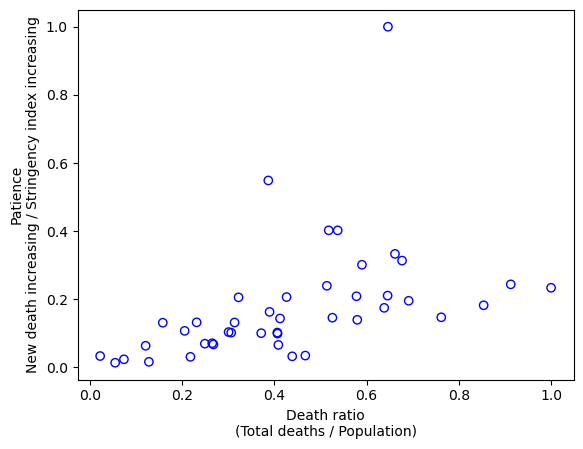

In [50]:
plt.scatter(df.death_ratio_scaled, df.patience_scaled, facecolors='none', edgecolors='blue')
plt.xlabel('Death ratio''\n''(Total deaths / Population)')
plt.ylabel('Patience''\n''New death increasing / Stringency index increasing')

# Step 2: Adaptive sampling

#### Countries positioned to the right of a theoretical line connecting (0,1) and (1,0) on the Death Ratio and Patience plot were considered high-risk. This approach allows for a relatively objective, quantitative boundary for high risk with minimal manual intervention. This is like defining what a high-risk is. Among these high-risk countries, the one with the smallest RLC was designated as 𝑇𝑠𝑒𝑣, representing the smallest observed high-risk country.
#### Among the countries to the right of the hypothetical high-risk baseline, the country with the shortest distance from (0,0) is Liechtenstein (0.7256). A circle with a radius of this distance is the minimum observed high-risk baseline (𝑇𝑠𝑒𝑣).

(0.0, 1.0936518691626766)

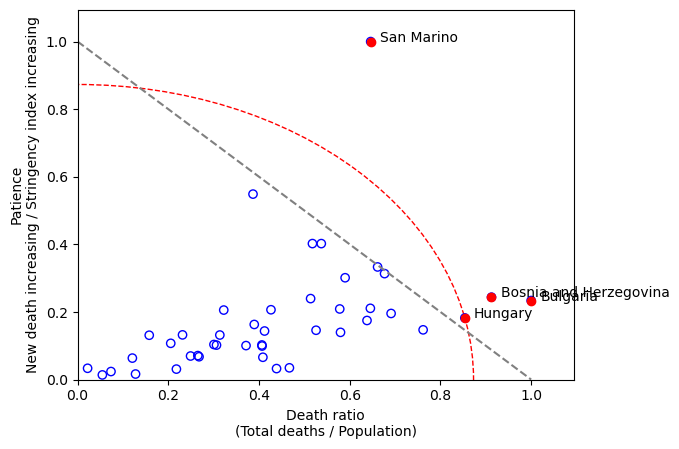

In [51]:
y_inter = np.max(df.patience_scaled)
x_inter = np.max(df.death_ratio_scaled)
plt.plot(np.linspace(0,1,100), y_inter-np.linspace(0,1,100)*(y_inter/x_inter), 
        linestyle='--', color = 'grey')

df['dis'] = df.patience_scaled - (y_inter-df.death_ratio_scaled*(y_inter/x_inter))
r = np.min(df.distance[df.dis > 0])
sel_country = df.country[df.distance >= r]

shp = patches.Ellipse((0,0), r*2,r*2, color='red', linestyle='--', fill=False)#,angle=45)
plt.gca().add_patch(shp)

plt.scatter(df.death_ratio_scaled, df.patience_scaled, facecolors='none', edgecolors='blue')
plt.scatter(df.death_ratio_scaled[df.country.isin(sel_country)],
           df.patience_scaled[df.country.isin(sel_country)], color = 'red')

rtick = np.max(df.death_ratio_scaled)*0.02
for i, j in enumerate(sel_country) :
    plt.text(df.death_ratio_scaled[df.country==j] + rtick, 
             df.patience_scaled[df.country==j], j, rotation = 0)

plt.xlabel('Death ratio''\n''(Total deaths / Population)')
plt.ylabel('Patience''\n''New death increasing / Stringency index increasing')
plt.xlim(0,)
plt.ylim(0,)


Distance of the smallest observed High-risk country (T_sev):  0.8730373832535333


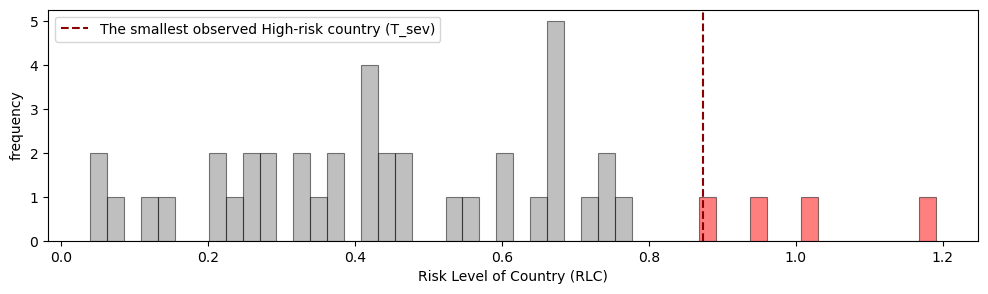

In [52]:
plt.figure(figsize=(12,3))
n, bins, patches = plt.hist(np.sqrt(df.patience_scaled**2+df.death_ratio_scaled**2), 
                            bins=50,color = 'grey', alpha=0.5, edgecolor = 'black' ,linewidth = 0.8)

for i in range(len(patches)-len(bins[bins>=r]), len(patches)): 
    patches[i].set_facecolor('red')
plt.axvline(r, linestyle='--', color = 'darkred', label = 'The smallest observed High-risk country (T_sev)')


data = df.distance.values
data = np.sort(data)[::-1]
t_sev = np.min(df.sort_values('distance').tail(len(sel_country)).distance)
print('Distance of the smallest observed High-risk country (T_sev): ',t_sev)

plt.xlabel('Risk Level of Country (RLC)')
plt.ylabel('frequency')
plt.legend()

#### The histogram of the adaptive sampling results is shown below. It exhibits a pattern opposite to the histogram of the Relative Likelihood Curve (RLC) observed earlier. Extreme values are sampled more frequently because only samples with a mean greater than 𝑇𝑠𝑒𝑣 are selected as candidates for extreme values. In the histogram, the area below 𝑇𝑠𝑒𝑣 represents potential candidate points where the threshold might be located.

#### The next step, Hill estimation, is calculated only for the range below 𝑇𝑠𝑒𝑣. Values exceeding 𝑇𝑠𝑒𝑣 are already classified as definitive extreme values (e.g., high-risk countries) and do not require further analysis.

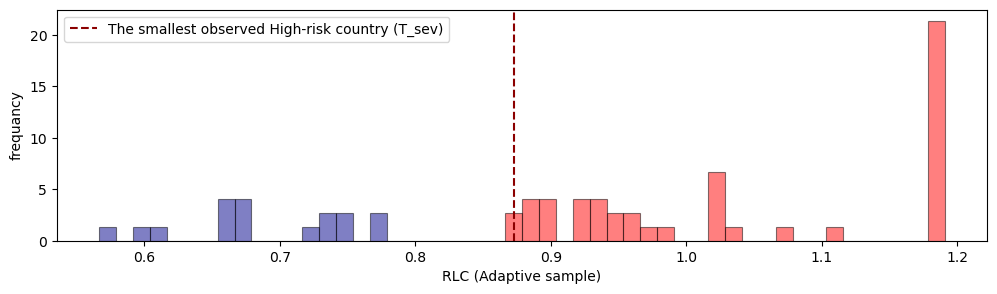

In [53]:
include_samples = data.copy()
over = data[data >= t_sev]
data = data[data >= over[0]-2*(over[0]-t_sev)]
selected_samples = []
subset_size = 2

for i in range(0, len(over)):
    for j in range(i+1, len(data)-i):
        if (data[i]+data[i+j])/2 >= t_sev:
            selected_samples.append(data[i])
            selected_samples.append(data[i+j])
            selected_samples.append((data[i]+data[i+j])/2)            

plt.figure(figsize=(12,3))
n, bins, patches = plt.hist(selected_samples, bins=50,color = 'darkblue', alpha=0.5, density=True,edgecolor = 'black' ,linewidth = 0.8)
for i in range(len(patches)-len(bins[bins>=r]), len(patches)): 
    patches[i].set_facecolor('red')
plt.axvline(r, linestyle='--', color = 'darkred', label = 'The smallest observed High-risk country (T_sev)')
plt.xlabel('RLC (Adaptive sample)')
plt.ylabel('frequancy')
plt.legend()

# Step 3: Hill estimation

#### The Hill estimator is calculated for samples below 𝑇𝑠𝑒𝑣. This estimator quantifies the heaviness of the distribution's tail by considering both the spacing and frequency of the data. According to the Pickands–Balkema–de Haan theorem, the tail of a distribution converges to a Generalized Pareto Distribution (GPD), regardless of the shape of the parent distribution. This implies the existence of a transition point where the tail behavior shifts, indicating a change in heaviness.

#### Traditionally, detecting this slope shift relied on subjective, visual judgments of the Hill plot. However, as shown in the figure below, it is challenging to identify the threshold point using the Hill estimator alone, particularly in cases with limited data. To address this issue, ATD applies the Savitzky-Golay filter.

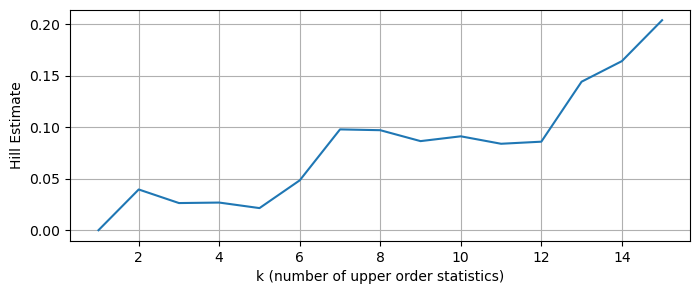

In [54]:
sampled_data = np.array(selected_samples.copy())
sampled_data = sampled_data[sampled_data < t_sev]

data_sorted = np.sort(sampled_data)[::-1]
k_values = np.arange(1, len(data_sorted))
hill_estimates = np.array([np.mean(np.log(data_sorted[:k]) - np.log(data_sorted[k])) for k in k_values])

plt.figure(figsize=(8,3))
plt.plot(k_values, hill_estimates)
plt.xlabel('k (number of upper order statistics)')
plt.ylabel('Hill Estimate')
plt.grid(True)

# Step 4: Savitzky-Golay Filtering and Inflection Point Detection

#### The Savitzky-Golay filtering technique smooths the data to minimize noise while preserving critical structural characteristics, such as inflection points. These features are essential for identifying shifts in the tail behavior of the distribution. This method effectively detects slope change points in the Hill estimator, which are challenging to locate visually. As more adaptive samples are extracted, these change points become increasingly evident.

Estimated threshold:  0.8094437349629111


Text(0, 0.5, 'Second derivated Hill Estimate')

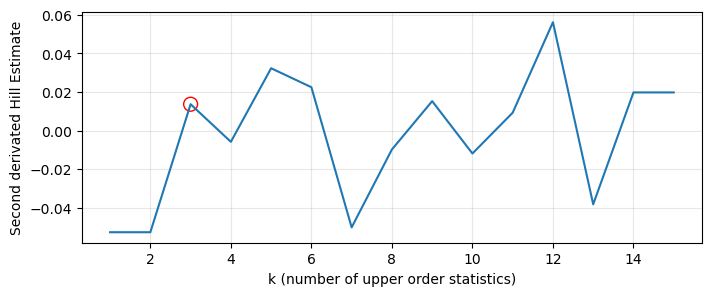

In [55]:
second_derivative = savgol_filter(hill_estimates, window_length=3, polyorder=2, deriv=2)

change_points = []
for i in range(1, len(second_derivative)-1):
    if (second_derivative[i]-second_derivative[i-1] < 0 and second_derivative[i+1]-second_derivative[i] > 0) or (second_derivative[i]-second_derivative[i-1] > 0 and second_derivative[i+1]-second_derivative[i] < 0):
        change_points.append(i)
loc = change_points[0]

plt.figure(figsize=(8,3))
plt.grid(alpha=0.3)
plt.plot(k_values, second_derivative)
plt.scatter(k_values[loc], second_derivative[loc], s=100, facecolors='none', edgecolors='r')
# plt.legend()

threshold_fin = (data_sorted[loc]+ t_sev)/2
print('Estimated threshold: ', threshold_fin)
plt.xlabel('k (number of upper order statistics)')
plt.ylabel('Second derivated Hill Estimate')

# Result of the Threshold Estimated by ATD

#### The threshold estimated by ATD differs from the observed minimum risk country (𝑇𝑠𝑒𝑣). As of December 31, 2020, ATD quantitatively estimated the threshold for identifying high-risk countries as 0.7041. At the same time, Spain was newly identified as a high-risk country by ATD.

#### ATD adapts to the given data to estimate a quantitative threshold. Unlike traditional methods, it does not rely on subjective intervention to determine the threshold, nor is it constrained by the shape of the parent distribution. Furthermore, ATD remains effective even with limited data, making it optimally suited for real-time monitoring applications.

#### For more details on ATD's high accuracy, refer to the examples of ATD applied to synthetic data.

(0.0, 1.0936518691626766)

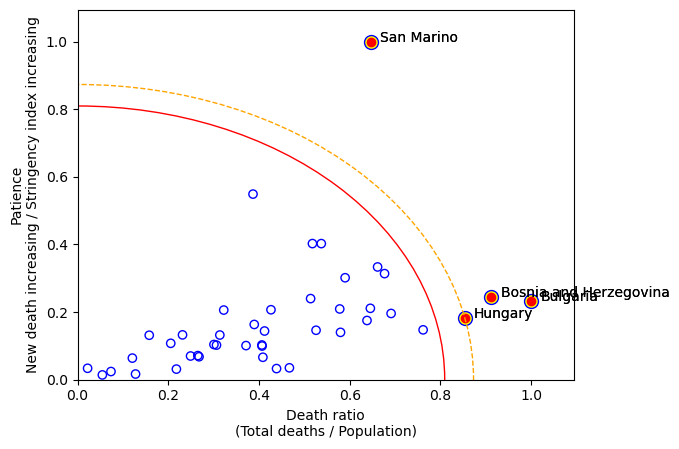

In [59]:
plt.scatter(df.death_ratio_scaled, df.patience_scaled, facecolors='none', edgecolors='blue')

sel_country2 = df.country[df.distance >= threshold_fin]

plt.scatter(df.death_ratio_scaled[df.country.isin(sel_country2)],
           df.patience_scaled[df.country.isin(sel_country2)],
            color = 'blue', s=100, facecolors='yellow', edgecolors='blue')

plt.scatter(df.death_ratio_scaled[df.country.isin(sel_country)],
           df.patience_scaled[df.country.isin(sel_country)],
            color = 'red')

import matplotlib.patches as patches

shp1=patches.Ellipse((0,0), r*2,r*2, color='orange', linestyle='--', fill=False, label = 'T_sev')
plt.gca().add_patch(shp1)

shp2=patches.Ellipse((0,0), threshold_fin*2,threshold_fin*2, color='red', linestyle='-', fill=False, label =' Threshold by ATD')
plt.gca().add_patch(shp2)

rtick = np.max(df.death_ratio_scaled)*0.02
for i, j in enumerate(sel_country2) :
    plt.text(df.death_ratio_scaled[df.country==j]+rtick, 
             df.patience_scaled[df.country==j], j, rotation = 0)    
for i, j in enumerate(sel_country) :
    plt.text(df.death_ratio_scaled[df.country==j]+rtick, 
             df.patience_scaled[df.country==j], j, rotation = 0)
# plt.legend()
plt.xlabel('Death ratio''\n''(Total deaths / Population)')
plt.ylabel('Patience''\n''New death increasing / Stringency index increasing')
plt.xlim(0,)
plt.ylim(0,)